In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement

station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
start_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
start_date

('2017-08-23',)

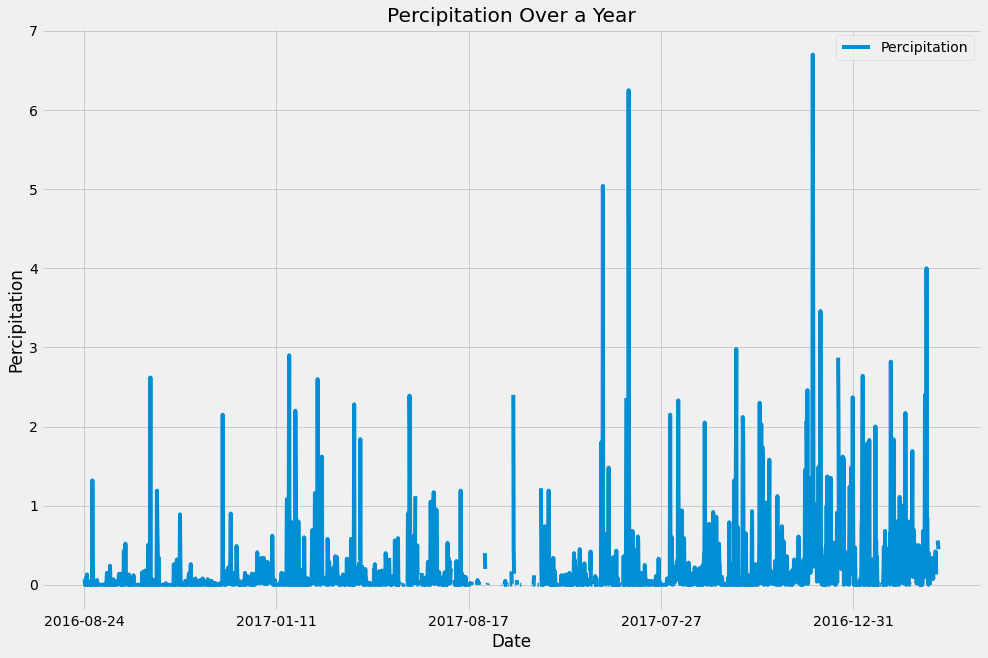

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.datetime.strptime(start_date.date, '%Y-%m-%d').date()
# Calculate the date one year from the last date in data set.
year_ago = recent_date - dt.timedelta(days=364)
year_ago

# Perform a query to retrieve the data and precipitation scores
recent_query =session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= year_ago).all()
recent_query

# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(recent_query, columns=["Date", "Percipitation"])
measurement_df.set_index("Date", inplace=True)

# Sort the dataframe by date
measurement_df.sort_index()
measurement_df

# Use Pandas Plotting with Matplotlib to plot the data
measurement_df.plot(figsize=(15,10))
plt.title("Percipitation Over a Year")
plt.xlabel("Date")
plt.ylabel("Percipitation")
plt.show()



In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_df.describe()

,Percipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(station).count()
station_count

9

In [25]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(measurement.station, func.count(measurement.station)).\
            group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
low_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
high_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
avg_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()

print(f'The lowest temperature at station USC00519281 is {low_temp}.')
print(f'The highest temperature at station USC00519281 is {high_temp}.')
print(f'The average temperature at station USC00519281 is {avg_temp}.')

The lowest temperature at station USC00519281 is [(54.0,)].
The highest temperature at station USC00519281 is [(85.0,)].
The average temperature at station USC00519281 is [(71.66378066378067,)].


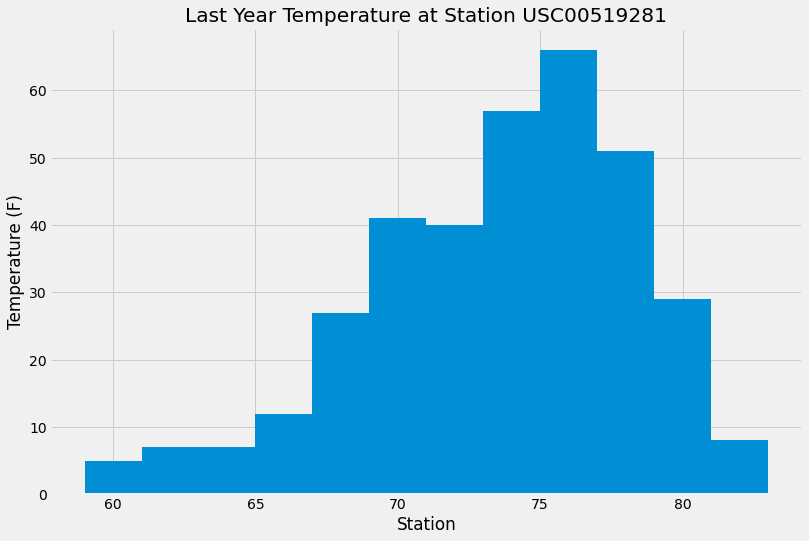

In [34]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_year = session.query(measurement.station, measurement.tobs).\
           filter(func.strftime('%Y-%m-%d', measurement.date) > year_ago).\
           filter(measurement.station == 'USC00519281').all()
# create a pandas dataframe
active_year_df = pd.DataFrame(active_year, columns=['station', 'tobs'])
active_year_df

# Create a histogram
active_year_df.hist(bins=12,figsize=(12, 8))
plt.xlabel('Station')
plt.ylabel('Temperature (F)')
plt.title('Last Year Temperature at Station USC00519281')
plt.show()

# Close session

In [35]:
# Close Session
session.close()